In [1]:
# Load images.
from skimage.io import imread, imshow
rawArr = imread('/home/jiongyi/jupyter/branched-networks/bead-motility/actin_seeds_dual_channel.tif')

In [2]:
# Reorganize stacks and scale to 16-bit
from skimage import img_as_uint
scalingFactor = 1 / (2**16 - 1)
actinArr = img_as_uint(rawArr[:, 0, :, :] * scalingFactor)
trpMyoArr = img_as_uint(rawArr[:, 1, :, :] * scalingFactor)

/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [3]:
from skimage.morphology import erosion, dilation, reconstruction
from skimage.util import invert
def openclose(inputArr, structuralElement):
    erodedArr = erosion(inputArr, structuralElement)
    openedArr = reconstruction(erodedArr, inputArr)
    dilatedArr = dilation(openedArr, structuralElement)
    ocArr = invert(reconstruction(invert(dilatedArr), invert(openedArr)))
    return ocArr

In [4]:
# Apply filters.
from numpy import zeros
from skimage.exposure import equalize_adapthist
from skimage.filters import gaussian
from skimage.morphology import white_tophat, square
from skimage import img_as_uint
noTimePoints, noRows, noColumns = actinArr.shape
filteredArr = zeros((noTimePoints, noRows, noColumns))
for i in range(noTimePoints):
    # Enhance contrast.
    claheArr = equalize_adapthist(actinArr[i, :, :])
    # Gaussian filter
    gaussianArr = gaussian(claheArr, sigma = 1)
    openClosedArr = openclose(gaussianArr, square(3))
    # Top-hat filtering to subtract background.
    tophatArr = white_tophat(openClosedArr, square(21))
    filteredArr[i, :, :] = tophatArr

/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/morphology/greyreconstruct.py:143: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  selem[[slice(d, d + 1) for d in offset]] = False
/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/morphology/greyreconstruct.py:161: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  images[[0] + inside_slices] = seed
/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/morphology/greyreconstruct.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecat

In [5]:
# Estimate background.
from numpy import mean, std
muBackground = mean(filteredArr[0, :, :].flatten())
sigmaBackground = std(filteredArr[0, :, :].flatten())
threshold = muBackground + 3 * sigmaBackground

In [6]:
# Initialize binarized array.
isActinArr = zeros(filteredArr.shape, dtype = bool)
isActinArr[0, :, :] = filteredArr[0, :, :] > threshold
noBackground = sum(~isActinArr[0, :, :].flatten())

In [7]:
# Iterate
for i in range(1, noTimePoints):
    # isActinArr[i, :, :] = distBackground.cdf(filteredArr[i, :, :]) > cdfThreshold
    isActinArr[i, :, :] = filteredArr[i, :, :] > threshold
    # Calculate new means and standard deviations.
    noNewBackground = sum(~isActinArr[i, :, :].flatten())
    muNewBackground = mean(filteredArr[i, :, :][~isActinArr[i, :, :]].flatten())
    sigmaNewBackground = std(filteredArr[i, :, :][~isActinArr[i, :, :]].flatten())
    # Update distribution.
    muBackground = (muBackground * noBackground + muNewBackground * noNewBackground) / (noBackground + noNewBackground)
    sigmaBackground = (sigmaBackground * noBackground + sigmaNewBackground * noNewBackground) / (noBackground + noNewBackground)
    #distBackground = norm(muBackground, sigmaBackground)
    threshold = muBackground + 3 * sigmaBackground

In [8]:
# Save images.
from skimage.io import imsave
imsave('is_actin.tiff', img_as_uint(isActinArr * (2**16 - 1)))
imsave('actin_channel_filtered.tiff', img_as_uint(filteredArr))

/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:126: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint16.
  .format(dtypeobj_in, dtypeobj_out))
/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:179: UserWarning: Downcasting int64 to uint16 without scaling because max value 65535 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [9]:
# Extract region properties.
from skimage.measure import regionprops, label
from skimage.segmentation import clear_border
regionPropertiesList = []
for i in range(noTimePoints):
    regionPropertiesList.append(regionprops(clear_border(label(isActinArr[i, :, :])), filteredArr[i, :, :]))

/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/segmentation/_clear_border.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True
/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/segmentation/_clear_border.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True


/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


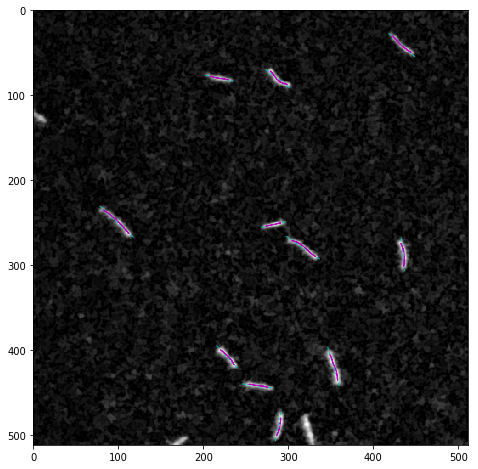

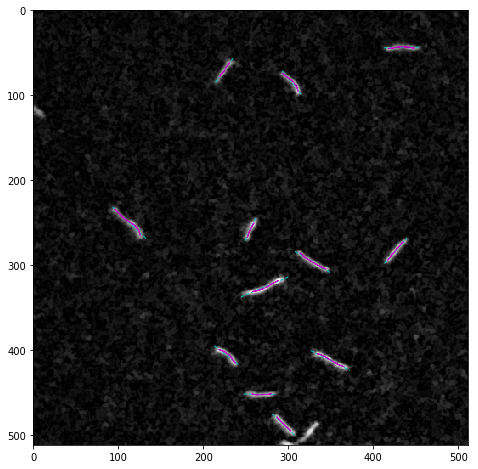

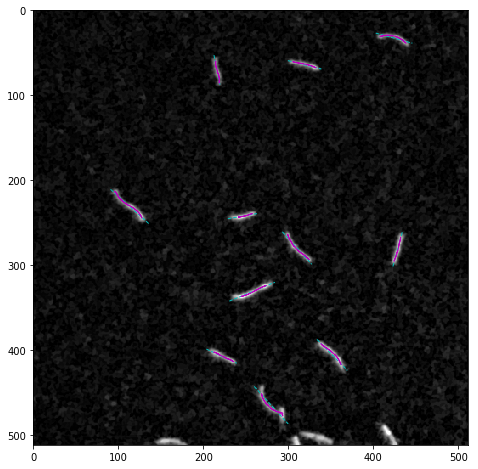

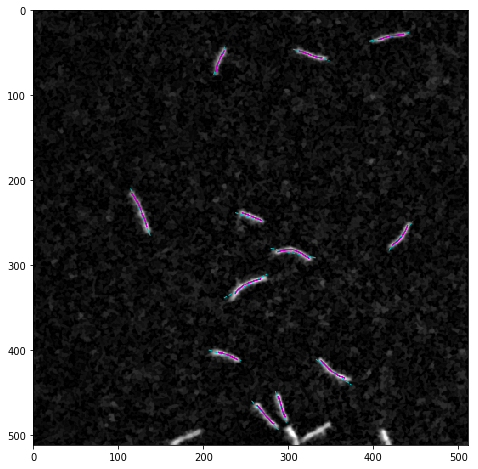

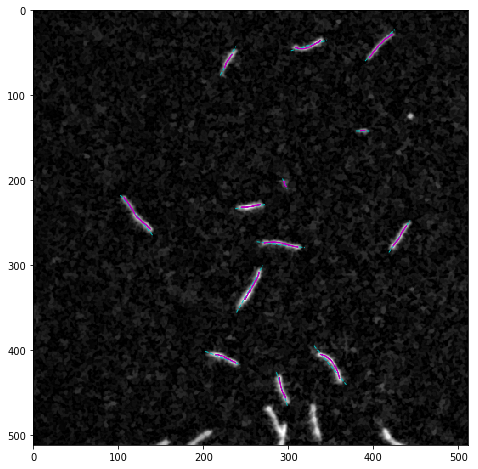

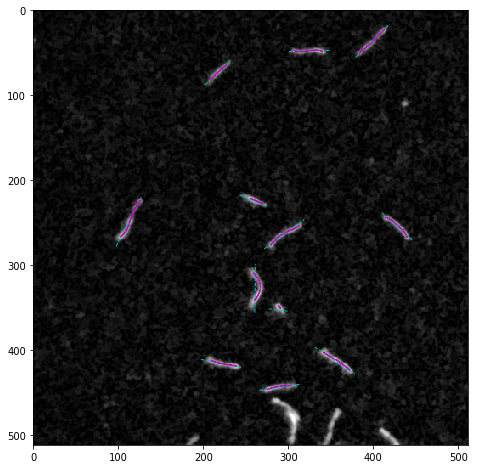

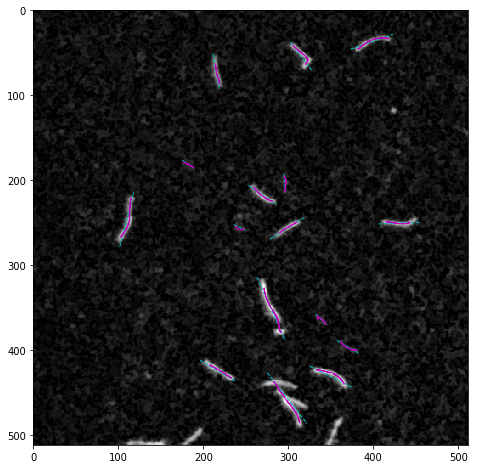

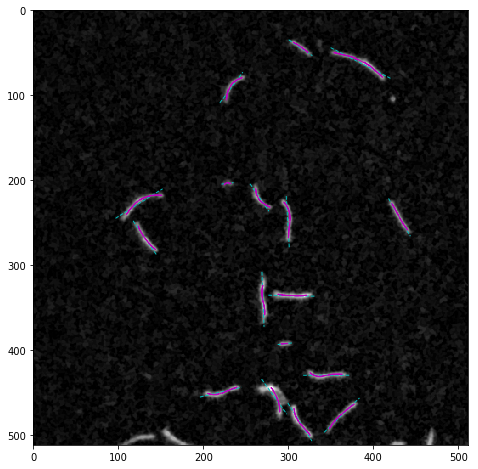

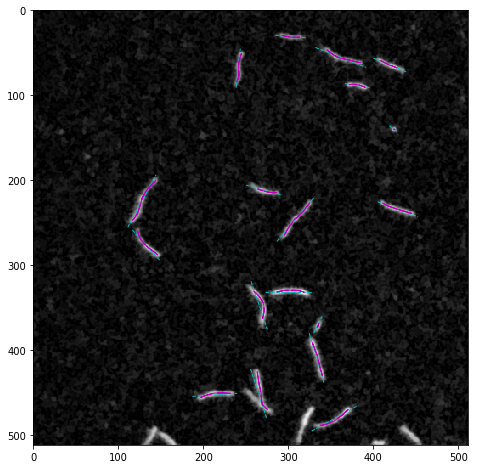

In [10]:
# Generate initial snakes.
from numpy import array, sin, cos, linspace
from skimage.exposure import equalize_adapthist
from skimage.segmentation import active_contour
from matplotlib.pyplot import subplots, plot, cm
for i in range(9):
    figureHandle, axesHandle = subplots(figsize = (8, 8))
    axesHandle.imshow(filteredArr[i, :, :], cmap = cm.gray)
    for j in range(len(regionPropertiesList[i])):
        if regionPropertiesList[i][j].area > 64:
            rCentroid, cCentroid = regionPropertiesList[i][j].centroid
            a = 0.5 * regionPropertiesList[i][j].major_axis_length
            theta = regionPropertiesList[i][j].orientation
            dx = a * cos(theta)
            dy = a * sin(theta)
            xInitial = cCentroid - dx
            xFinal = cCentroid + dx
            yInitial = rCentroid + dy
            yFinal = rCentroid - dy
            xArr = linspace(xInitial, xFinal, 100)
            yArr = linspace(yInitial, yFinal, 100)
            initialCoordsArr = array([xArr, yArr]).T
            snakesCoordsList = active_contour(filteredArr[i, :, :], initialCoordsArr, alpha = -0.00001, w_line = 0.75, w_edge = -0.25, max_px_move = 0.1)
            axesHandle.plot(initialCoordsArr[:, 0], initialCoordsArr[:, 1], '--c', linewidth = 1)
            axesHandle.plot(snakesCoordsList[:, 0], snakesCoordsList[:, 1], 'm', linewidth = 1)